# Exploring the NASDAQOMX india indices

In [1]:
library(tidyverse)
library(ggthemes)
library(odbc)
library(plutoR)
library(quantmod)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")
source("goofy/misc.common.R")

nasdaqOmx <- NasdaqOmx()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend

Registering fonts with R

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package

In [2]:
indexMeta <- nasdaqOmx$Meta() %>%
    inner_join(nasdaqOmx$TimeSeries()) %>%
    group_by(ID, CODE, NAME) %>%
    filter(NAME %like% '% India %') %>%
    summarize(ST = min(TIME_STAMP), ET = max(TIME_STAMP)) %>%
    arrange(NAME) %>%
    collect()

indexMeta %>%
    print(n = Inf, width = Inf)

Joining, by = "ID"
Warning message:
“Missing values are always removed in SQL.
Use `MIN(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”Warning message:
“Missing values are always removed in SQL.
Use `MAX(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”

# A tibble: 11 x 5
# Groups:   ID, CODE [11]
         ID CODE      NAME                                          ST        
      <int> <chr>     <chr>                                         <date>    
 1 13120874 NQIN1000T NASDAQ India Basic Matls TR Index (NQIN1000T) 2001-03-30
 2 13120916 NQIN3000T NASDAQ India Cnsmr Goods TR Index (NQIN3000T) 2001-03-30
 3 13120939 NQIN5000T NASDAQ India Cnsmr Svcs TR Index (NQIN5000T)  2005-03-31
 4 13120986 NQIN8000T NASDAQ India Financials TR Index (NQIN8000T)  2001-03-30
 5 13121029 NQIN4000T NASDAQ India Health Care TR Index (NQIN4000T) 2001-03-30
 6 13121072 NQIN2000T NASDAQ India Inds TR Index (NQIN2000T)        2001-03-30
 7 13121187 NQIN0001T NASDAQ India Oil & Gas TR Index (NQIN0001T)   2004-09-30
 8 13121253 NQIN9000T NASDAQ India Tech TR Index (NQIN9000T)        2001-03-30
 9 13121274 NQIN6000T NASDAQ India Telecom TR Index (NQIN6000T)     2006-03-31
10 13121272 NQINT     NASDAQ India TR Index (NQINT)                 2001-03-30
11 1312

In [3]:
#grab the data
startDate <- max(indexMeta$ST)
endDate <- min(indexMeta$ET)

nqRets <- NULL

for(id in indexMeta$ID){
    nqVals <- nasdaqOmx$TimeSeries() %>%
        filter(ID == id & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
        select(TIME_STAMP, CLOSE) %>%
        collect()
    
    nqRets <- merge.xts(nqRets, dailyReturn(xts(nqVals$CLOSE, nqVals$TIME_STAMP)))
}

names(nqRets) <- indexMeta$CODE

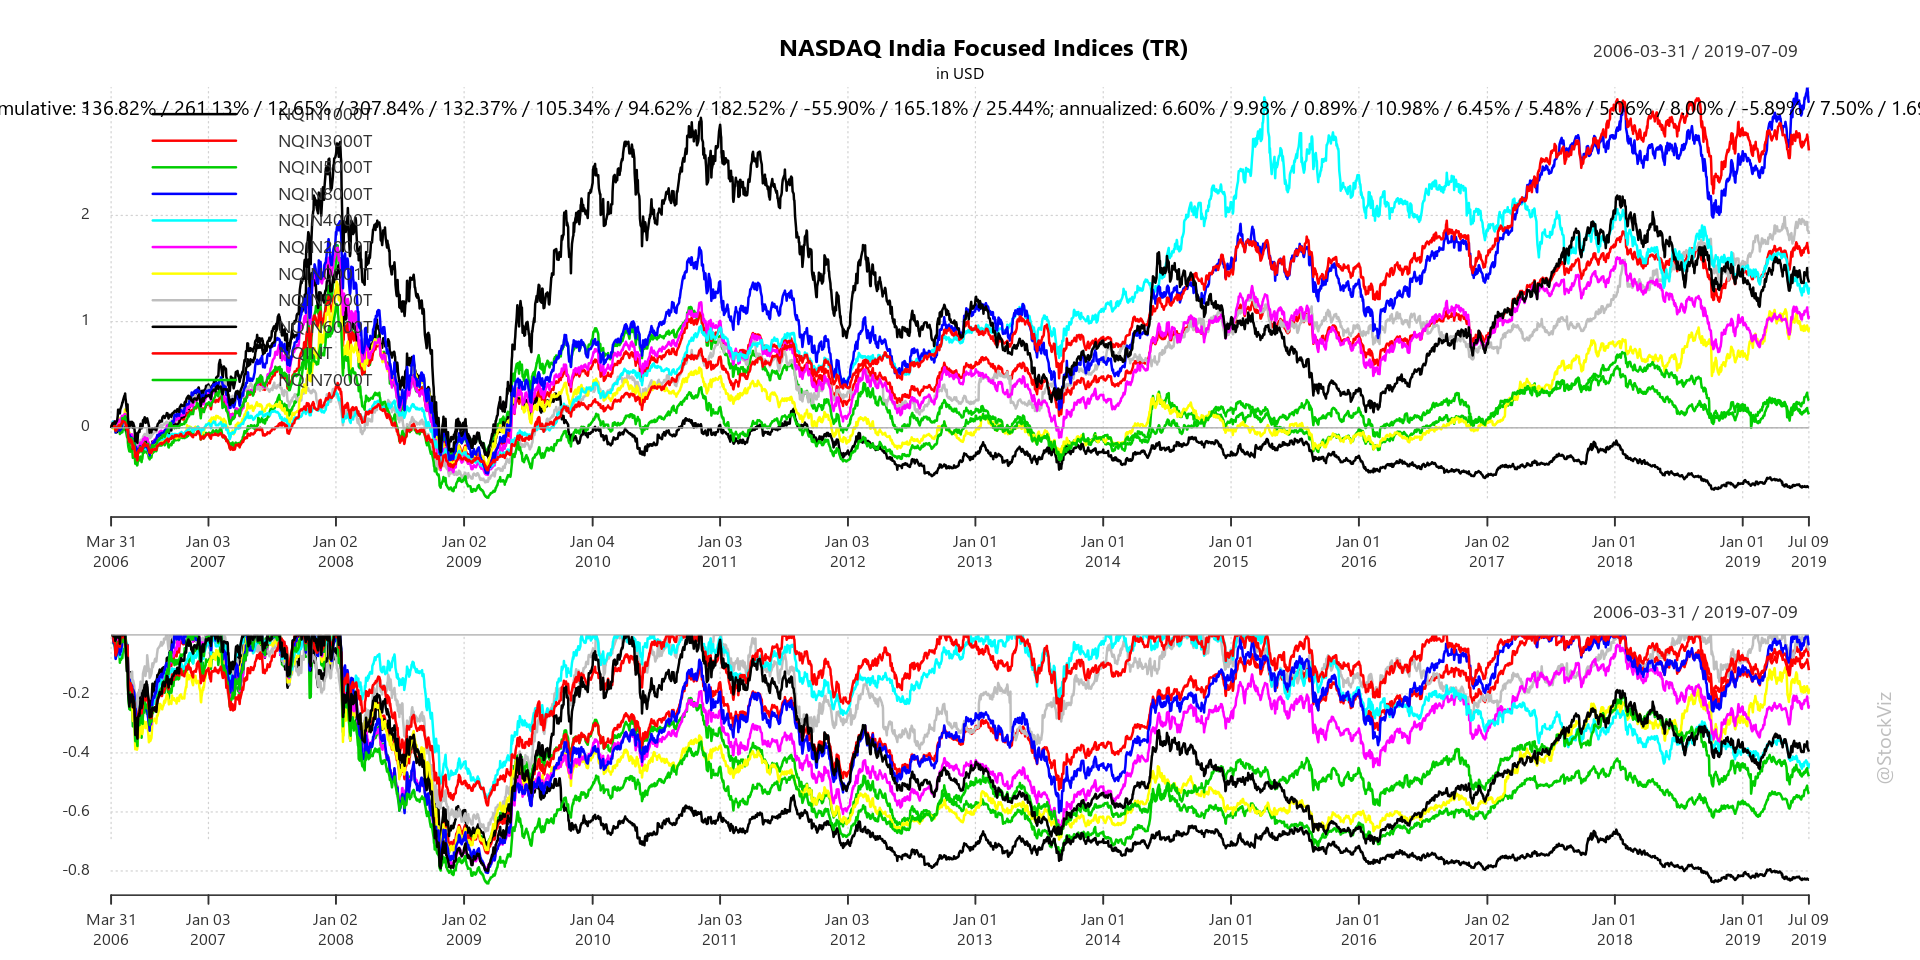

In [4]:
#plot cumulative returns
Common.PlotCumReturns(nqRets, "NASDAQ India Focused Indices (TR)", "in USD")

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)